# Импорт и загрузка данных

In [ ]:
! pip install catboost
! pip install feature_engine
! pip install pickle

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns
from catboost import CatBoostClassifier
%matplotlib inline

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [5]:
RESOLUTION = 8

In [6]:
# check if the notebook is running on google colab or not
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [7]:
data_8 = os.path.join("sample_data", "final_training_dataset.xlsx") if IN_COLAB else os.path.join("final_training_dataset.xlsx") 
data = pd.read_excel(os.path.join(data_8), usecols=lambda c: 'Unnamed:' not in c)
data_org = data.copy()
# first drop the h3, lat and lng attributes
data.drop(columns=['h3', 'lat', 'lng'], inplace=True)
# consider this as a classification problem
data['y'] = (data['y'] > 0).astype(int)
data = data.astype(int)

In [8]:
y = data['y']
data.pop('y')
from sklearn.model_selection import train_test_split
df_train, df_test, y_train , y_test = train_test_split(data, y, test_size=0.2, random_state=11, stratify=y)
df = df_train.copy()

# Общие функции

In [9]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
        
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt


In [10]:
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
import pickle


CV = StratifiedKFold(n_splits=5) 
ll_score = make_scorer(log_loss,greater_is_better=True, needs_proba=True)

In [11]:
# define a function to apply the same function on both train and test datasets
def apply(function, df_train, df_test, axis=1):
    df_train = df_train.apply(function, axis=axis)
    df_test = df_test.apply(function, axis=axis)
    return df_train, df_test

def drop(cols, df_train, df_test):
    if isinstance(cols, str):
        cols = [cols]
    return df_train.drop(columns=cols), df_test.drop(columns=cols)    

In [12]:
def divide(a, b):
    return a / b if b != 0 else 0

In [13]:
def pdf_feat(df, col):
    sns.displot(df, x=col, hue='y', palette='dark')
    plt.show()

In [14]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    # discrete features are the ones with type int
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]

    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
def mi_scores(x, y):
    mi_scores = make_mi_scores(x, y)
    plot_mi_scores(mi_scores)
    plt.show()

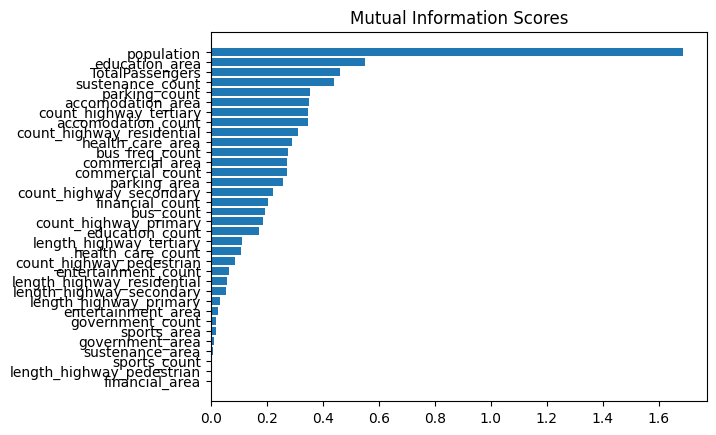

In [15]:
mi_scores(df, y_train)

# Нормализация данных

In [16]:
out_dict = {}
for c in df.columns:
    # for each column: filter by rows who do not have zero at that column and retrive the column
    q3, q1 = np.percentile(df[df[c] != 0][c], [75, 25])
    iqr = q3 - q1
    min_v = q1 - 1.5 * iqr
    max_v = q3 + 1.5 * iqr
    out_dict[c] = (min_v, max_v)


cols = df.columns
def fix_outliers(row):
    for c in cols:
        v = row[c]
        min_v, max_v = out_dict[c]
        if v != 0 and v > max_v:
            row[c] = max_v
        elif v != 0 and v < min_v:
            row[c] = min_v
    return row

df_t = df.apply(fix_outliers, axis=1)

In [17]:
bus_s = 'bus_count'
bus_f = 'bus_freq_count'
metro  = 'TotalPassengers'
def set_tranport(row):
    row['transport'] = (row[bus_s] + 2) * np.sqrt(np.log(row[bus_f] + 2) ) + row[metro]
    return row

a_a = 'accomodation_area'
a_c = 'accomodation_count'
pop = 'population'

def get_acc_feats(row):
    row['density'] = divide(row[pop], row[a_a])
    row['app_area'] = divide(row[a_a], row[a_c]) 
    row[a_a] / row[a_c] if row[a_c] != 0 else 0
    return row
# set accomodation and transport
df, df_test = apply(get_acc_feats, df, df_test)
df, df_test = apply(set_tranport, df, df_test)

df, df_test = drop(["count_highway_pedestrian", "length_highway_pedestrian"], df, df_test)

# mi_scores(df, y_train)


In [18]:
def display_correlation(df, threshold=0.2):
    r = df.corr(method="spearman")
    r_display = r[(r['y'] > threshold) | (r['y'] < -threshold)]
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(r_display, vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Spearman Correlation")
    plt.show()
    return(r)


In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feat_names = df.columns
df_s = pd.DataFrame(scaler.fit_transform(df), columns=feat_names)
df_test_s = pd.DataFrame(scaler.transform(df_test), columns=feat_names)

[0.81860465 0.80465116 0.80697674 0.7972028  0.81162791]
[0.82242991 0.81220657 0.80885781 0.84029484 0.79680365]
[0.84107327 0.83075335 0.82972136 0.84297521 0.82438017]
<function cross_val_score at 0x7fe516e8f010>
[0.36072479 0.34329933 0.37706722 0.36466166 0.36457516]
[[582  92]
 [111 426]]
              p     count
p      1.000000  0.671148
count  0.671148  1.000000


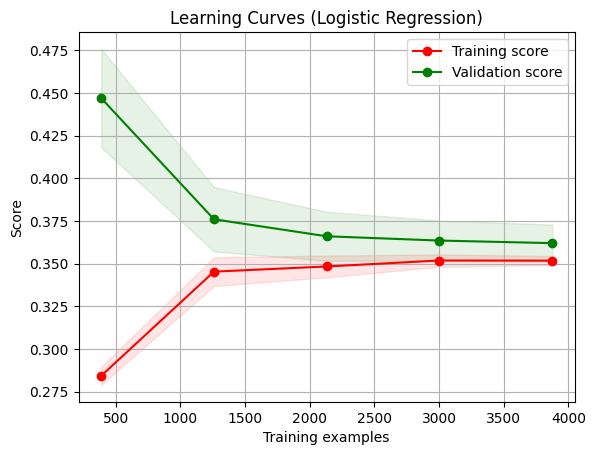

In [20]:
metrics = [accuracy_score, recall_score, precision_score]

log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(df_s, y_train)


print(cross_val_score(log_reg, df_s, y_train, cv=CV, scoring=make_scorer(recall_score)))
print(cross_val_score(log_reg, df_s, y_train, cv=CV, scoring=make_scorer(precision_score)))
print(cross_val_score(log_reg, df_s, y_train, cv=CV, scoring='accuracy'))
print(cross_val_score)

print(cross_val_score(log_reg, df_s, y_train, cv=CV, scoring=ll_score))

from sklearn.metrics import confusion_matrix
y_pred = log_reg.predict(df_test_s)
print(confusion_matrix(y_test, y_pred))

y_pred_prob = log_reg.predict_proba(df_test_s)

y_n = data_org.loc[y_test.index,  'y']
# print(y_pred_prob[:5])
# print(y_n[:5])
print(pd.DataFrame({"p":y_pred_prob[:, 1], "count": y_n}).corr())

# Plot learning curves
title = "Learning Curves (Logistic Regression)"
plot_learning_curve(log_reg, title, df_s, y_train, cv=CV, scoring=ll_score)
plt.show()


## Применение необходимых преобразований

In [21]:
import scipy.stats as st
# first let's drop some columns:
drop_columns = ["financial_area", "health_care_area", "entertainment_area", "sustenance_area", 
                "sports_count", "sports_area", "government_area", "government_count", metro, bus_f]

box_cox_cols = ["education_area", "parking_area", "accomodation_count", "accomodation_area",
                 "count_highway_secondary", "length_highway_secondary",
                "count_highway_residential", "density", "app_area", "length_highway_tertiary"]
discretize_cols = ["count_highway_primary", "length_highway_primary", "education_count", "financial_count", "commercial_count", "commercial_area", "health_care_count", 
                   "sustenance_count", "length_highway_secondary", "length_highway_tertiary", "length_highway_residential"]

df, df_test = drop(drop_columns, df, df_test)


In [22]:
# # трансформация с помощью box cox
for c in box_cox_cols:
    df[c] ,_params = st.boxcox(df[c] + 1)
    df_test[c] = st.boxcox(df_test[c] + 1, _params)            

In [23]:
# дискретизировать
from feature_engine.discretisation import DecisionTreeDiscretiser
discretize_cols
disc = DecisionTreeDiscretiser(cv=3, param_grid={"max_depth": [2, 3], "random_state":[11]} , random_state=11, scoring='precision', variables=discretize_cols, regression=False)

# fit the transformer
df_t= disc.fit_transform(df, y_train)
df_test_t = pd.DataFrame(disc.transform(df_test), columns=df_test.columns)

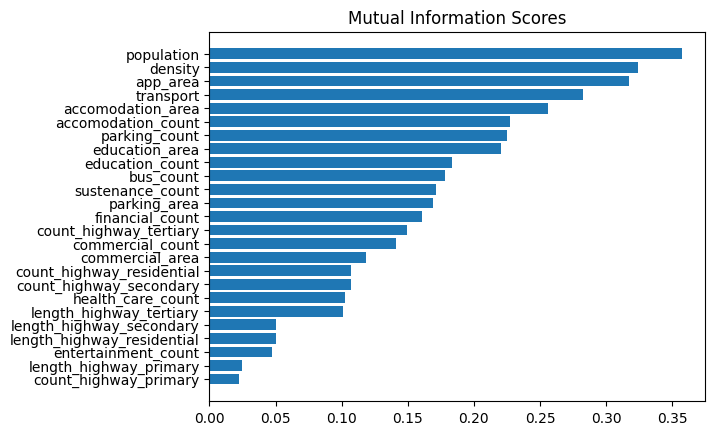

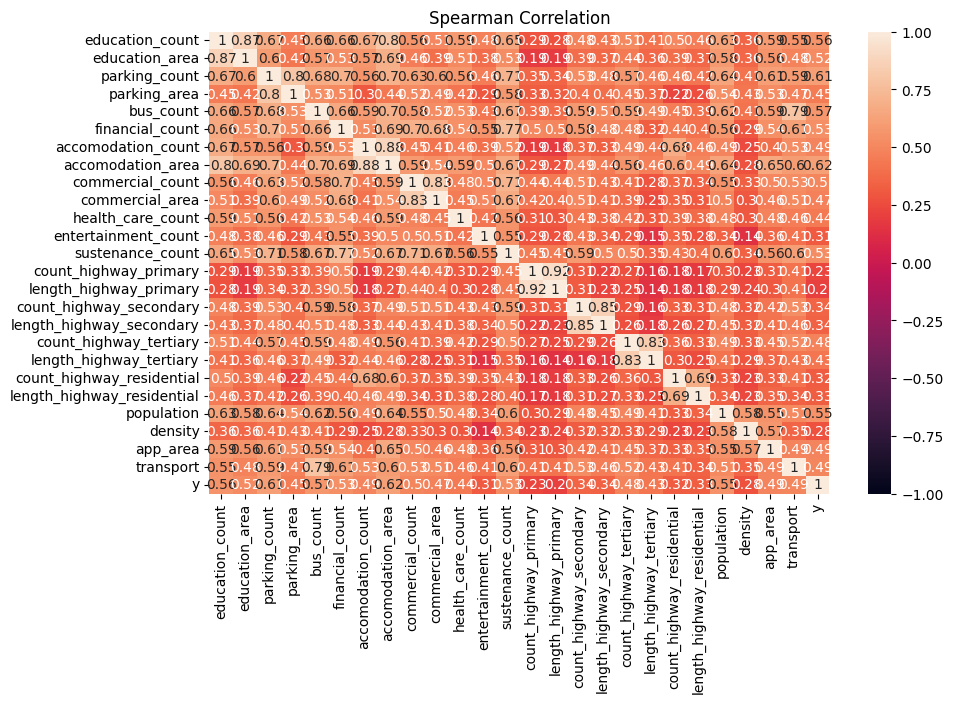

,education_count,education_area,parking_count,parking_area,bus_count,financial_count,accomodation_count,accomodation_area,commercial_count,commercial_area,...,length_highway_secondary,count_highway_tertiary,length_highway_tertiary,count_highway_residential,length_highway_residential,population,density,app_area,transport,y
education_count,1.000000,0.871533,0.672122,0.453457,0.659929,0.658914,0.673482,0.799636,0.558366,0.507528,...,0.432168,0.514212,0.411173,0.503606,0.458128,0.632122,0.358167,0.590521,0.553798,0.561557
education_area,0.871533,1.000000,0.595262,0.422492,0.567812,0.526577,0.570264,0.693991,0.457445,0.394727,...,0.367782,0.444725,0.363608,0.392952,0.367117,0.581451,0.360174,0.562241,0.476778,0.520733
parking_count,0.672122,0.595262,1.000000,0.801649,0.678806,0.698039,0.560630,0.699853,0.631707,0.602911,...,0.480966,0.574388,0.458433,0.457364,0.418574,0.636387,0.410812,0.605840,0.589786,0.608024
parking_area,0.453457,0.422492,0.801649,1.000000,0.533871,0.512827,0.300919,0.436897,0.517139,0.488330,...,0.395218,0.454337,0.371891,0.218775,0.259406,0.536777,0.428842,0.528872,0.470016,0.452728
bus_count,0.659929,0.567812,0.678806,0.533871,1.000000,0.656330,0.588558,0.701651,0.577083,0.524337,...,0.514924,0.588059,0.493450,0.454068,0.391683,0.624571,0.408443,0.587490,0.791244,0.567600
financial_count,0.658914,0.526577,0.698039,0.512827,0.656330,1.000000,0.530926,0.691758,0.700036,0.677724,...,0.479902,0.477907,0.324952,0.439161,0.398446,0.563887,0.292680,0.537199,0.611905,0.531975
accomodation_count,0.673482,0.570264,0.560630,0.300919,0.588558,0.530926,1.000000,0.882824,0.449998,0.410772,...,0.333439,0.491845,0.439875,0.676529,0.461002,0.489475,0.247683,0.398208,0.525052,0.487642
accomodation_area,0.799636,0.693991,0.699853,0.436897,0.701651,0.691758,0.882824,1.000000,0.593131,0.544630,...,0.441726,0.559125,0.462352,0.603028,0.493372,0.638975,0.275427,0.654428,0.596655,0.615789
commercial_count,0.558366,0.457445,0.631707,0.517139,0.577083,0.700036,0.449998,0.593131,1.000000,0.832081,...,0.426968,0.412206,0.284876,0.369573,0.343686,0.553389,0.331635,0.501013,0.530043,0.497183
commercial_area,0.507528,0.394727,0.602911,0.488330,0.524337,0.677724,0.410772,0.544630,0.832081,1.000000,...,0.412567,0.389955,0.254395,0.353696,0.311157,0.499247,0.304123,0.457145,0.508962,0.469644


In [24]:
mi_scores(df_t, y_train)
df_t['y'] = y_train
display_correlation(df_t)

In [25]:
df_t.pop('y')
df = df_t.copy()
df_test = df_test_t.copy()

In [26]:
df.columns

Index(['education_count', 'education_area', 'parking_count', 'parking_area',
       'bus_count', 'financial_count', 'accomodation_count',
       'accomodation_area', 'commercial_count', 'commercial_area',
       'health_care_count', 'entertainment_count', 'sustenance_count',
       'count_highway_primary', 'length_highway_primary',
       'count_highway_secondary', 'length_highway_secondary',
       'count_highway_tertiary', 'length_highway_tertiary',
       'count_highway_residential', 'length_highway_residential', 'population',
       'density', 'app_area', 'transport'],
      dtype='object')

In [27]:
# applying PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
pca = PCA(n_components=0.95)

df_s = pd.DataFrame(ss.fit_transform(df), columns=df.columns)
df_test_s = pd.DataFrame(ss.transform(df_test), columns=df_test.columns)

df_p = pd.DataFrame(pca.fit_transform(df_s))
df_test_p = pd.DataFrame(pca.transform(df_test_s))

df = df_p.copy()
df_test = df_test_p.copy()

[0.86046512 0.84418605 0.85116279 0.80885781 0.84883721]
[0.77405858 0.79431072 0.77542373 0.81074766 0.77167019]
[0.82662539 0.83384933 0.8245614  0.83161157 0.82128099]
<function cross_val_score at 0x7fe516e8f010>
[0.36719308 0.35718137 0.40057468 0.37097241 0.37850692]
[[551 123]
 [ 83 454]]
              p     count
p      1.000000  0.632114
count  0.632114  1.000000


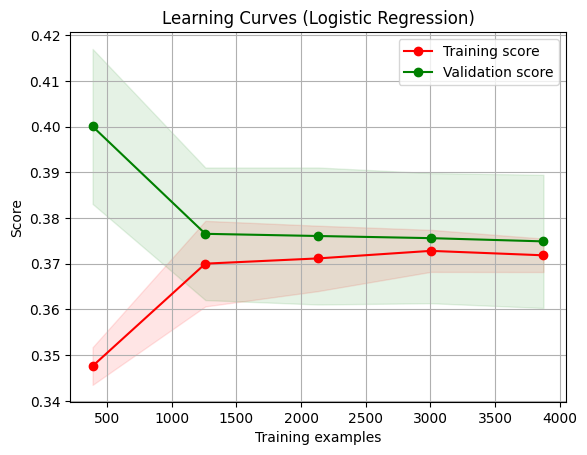

In [28]:
# scaler = StandardScaler()
# feat_names = df.columns
# df_s = pd.DataFrame(scaler.fit_transform(df), columns=feat_names)
# df_test_s = pd.DataFrame(scaler.transform(df_test), columns=feat_names)

metrics = [accuracy_score, recall_score, precision_score]

log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(df, y_train)


print(cross_val_score(log_reg, df, y_train, cv=CV, scoring=make_scorer(recall_score)))
print(cross_val_score(log_reg, df, y_train, cv=CV, scoring=make_scorer(precision_score)))
print(cross_val_score(log_reg, df, y_train, cv=CV, scoring='accuracy'))
print(cross_val_score)

print(cross_val_score(log_reg, df, y_train, cv=CV, scoring=ll_score))

from sklearn.metrics import confusion_matrix
y_pred = log_reg.predict(df_test)
print(confusion_matrix(y_test, y_pred))

y_pred_prob = log_reg.predict_proba(df_test)

y_n = data_org.loc[y_test.index,  'y']
# print(y_pred_prob[:5])
# print(y_n[:5])
print(pd.DataFrame({"p":y_pred_prob[:, 1], "count": y_n}).corr())

# Plot learning curves
title = "Learning Curves (Logistic Regression)"
plot_learning_curve(log_reg, title, df, y_train, cv=CV, scoring=ll_score)
plt.show()


# Hyperparameter Tuning and choosing the model

In [27]:
metrics = [accuracy_score, recall_score, precision_score]

In [28]:
def hypertune_model(estimator, params:dict,estimator_name,  X_train, y_train, X_test, y_test, 
                    cv=None, polys=None, random=False, ll=False):
    if polys is None:
        polys = [1, 2]
    
    if cv is None:
        cv = CV
        
    steps = [('scaler', StandardScaler()) 
            ,('poly_feats', PolynomialFeatures())
            , ('estimator', estimator)]

    new_params = {} 
    new_params['poly_feats__degree'] = polys
    
    for k, v in params.items():
        new_params['estimator__' + k] = v
    pipe = Pipeline(steps=steps)
    scoring = {"recall": "recall" ,  "log_loss": ll_score}
        
    if ll:
        if random:
            search = RandomizedSearchCV(pipe, new_params, scoring=scoring, refit='log_loss')
        else:
            search = GridSearchCV(pipe, new_params, scoring=scoring, refit='log_loss')
    else:
        if random:
            search = RandomizedSearchCV(pipe, new_params, scoring='recall')
        else:
            search = GridSearchCV(pipe, new_params, scoring='recall')
              
    search.fit(X_train, y_train)
    best_est, best_para = search.best_estimator_, search.best_params_
    ll = 0
    
    try:
        y_pred = best_est.predict_proba(X_test)
        ll = log_loss(y_test, list(y_pred[:, 1]))
    except:
        ll = 0

    y_pred = best_est.predict(X_test)
    rec = recall_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred) 
    
    test_results = {"recall": rec, "precision": pre,  "accuracy": acc, "log loss": ll}

    pickle.dump(best_est, open(f"{estimator_name}.sav", 'wb'))
    return best_est, best_para, search.cv_results_, test_results

In [28]:
from sklearn.linear_model import LogisticRegression

lasso_param = {"C": np.logspace(-3, 2, 40)}
lasso_param = {"C": [0.1]}
lasso = LogisticRegression(max_iter=3000, penalty='l1', solver='saga')

lasso_pack = hypertune_model(lasso, lasso_param , "Lasso", df, y_train, df_test, y_test)
lasso_res = lasso_pack[-1]
print(lasso_res)

{'recall': 0.8677839851024208, 'precision': 0.8306595365418895, 'accuracy': 0.8629232039636664, 'log loss': 0.33100980813577113}


### SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', probability=True) 
svm_params = {'C': np.logspace(-1, 2, 20), 'gamma':  np.logspace(-3, -1, 10)}
svm_pack = hypertune_model(svm, svm_params, "SVM",df, y_train, df_test, y_test, polys=[1], ll=True)
svm_res = svm_pack[-1]
print(svm_res)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_params = {"weights": ["distance"], "n_neighbors":list(range(11, 31, 2))}

knn_pack = hypertune_model(knn, knn_params, "KNN", df, y_train, df_test, y_test, ll=True)
knn_res = knn_pack[-1]

print(knn_res)

KNearestNeighbors_test_loss_score: 1.023841367147584
KNearestNeighbors_test_precision:0.84375


## CatBoost Classifier

In [ ]:
ctb_params = {'depth'         : [4,5,6],
              'learning_rate' : np.linspace(0.01, 0.1, 5),
              'iterations'    : [50,60,70],
              'loss_function': ['Logloss'],
              'random_state': [42]
              }

ctb = CatBoostClassifier(verbose=False)

ctb_pack = hypertune_model(ctb, ctb_params, "CTB", df, y_train, df_test, y_test)

ctb_res = ctb_pack[-1]

print(ctb_res)


## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rdf_params = {"max_depth": list(range(2, 6)), 
              "n_estimators":[100, 150, 200, 220], 
              "min_samples_leaf":list(np.linspace(0.02, 0.1, 6)), "max_samples": [0.8, 0.85, 0.9]}

rdf = RandomForestClassifier() 

rdf_pack = hypertune_model(rdf, rdf_params, "RDF", df, y_train, df_test, y_test)

ref_res = rdf_pack[-1]
print(ref_res)

RandomForestClassifier_test_loss_score: 0.3301044813638794
RandomForestClassifier_test_precision:0.8509615384615384


In [29]:
def evaluate(best_est, X_test, y_test):
    try:
        y_pred = best_est.predict_proba(X_test)
        ll = log_loss(y_test, list(y_pred[:, 1]))
    except:
        ll = 0

    y_pred = best_est.predict(X_test)
    rec = recall_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred) 
    
    test_results = {"recall": rec, "precision": pre,  "accuracy": acc, "log loss": ll}
    return test_results

In [30]:
best_model = pickle.load(open(os.path.join("models","XGB.sav"), 'rb'))
print(best_model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=600,
              n_jobs=1, nthread=1, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, ...)


In [31]:
best_model.fit(df, y_train)
print(evaluate(best_model, df_test, y_test))

[12:03:31] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


{'recall': 0.9031657355679702, 'precision': 0.9099437148217636, 'accuracy': 0.9174236168455822, 'log loss': 0.2295252442154972}


In [36]:
best_ctb = pickle.load(open(os.path.join("models","CTB.sav"), 'rb'))
print(best_ctb)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly_feats', PolynomialFeatures()),
                ('estimator',
                 <catboost.core.CatBoostClassifier object at 0x7fe4fc3eebc0>)])


/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning

In [37]:
best_ctb.fit(df, y_train)
evaluate(best_ctb, df_test, y_test)

{'recall': 0.8864059590316573,
 'precision': 0.8981132075471698,
 'accuracy': 0.9050371593724195,
 'log loss': 0.2718060665452198}